# PHYS20762 - Project 3 - Monte Carlo Method

Alexander Stansfield <br>
University of Manchester <br>
May 2022

In [159]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.constants as const

plt.rcParams.update({'font.size': 20})
plt.style.use('default')

# Theory for random number generation

The Monte Carlo method genrally refers to using a random number generator to solve problems. For example, if the random number generator is created such that the probability distribution of the random number generation follows that of the expected behaviour of the system, then the generator can be used to predict the behaviour and, more importantly, characteristics of the system. However, this method can also be used to solve integtals and estimate the value of universal constant, such as $\pi$.

Random numbers are required for this process BLAH EXPLAIN WHY HERE YAY

In this project, we shall use Monte Carlo's method to predict the behaviour of neutrons going through different materials and as such calculate the material's macroscopic characteristics. We shall use numpy's built in np.randon.uniform to create an array of uniformally distributed random numbers, but since the intensity of radiation through a material can be described as:

$$
I(x) = I_0e^{-\frac{x}{\lambda}}
$$

where $I_0$ is the initial raditiation intensity, $x$ is the thickness of the material and $\lambda$ is a constant (found to be the mean free path of a neutron travelling through the material), we shall need to create exponential random number generator. The first part of this project will be to create the functions necessary to simulate the neutrons and the second part will have a full simulation for different materials. 

Below is a simple bar plot to picture the behaviour of a uniform distribution. np.random.uniform is used to generate 1000 random numbers between 0 and 1, and the frequency that a number lies in between a given range is plotted. For 1000 numbers the frequency (density) varies an appreciable amount. However, for more points, all the height of the bars will approach the same number, for this plot it will be 1, shown by the red line. This describes a uniform distribution because every number is equally likely to be generated. 

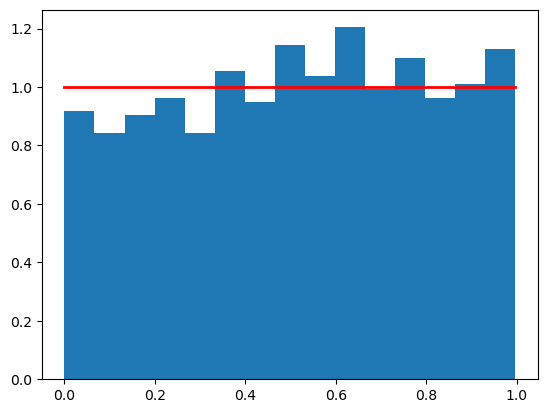

In [160]:
s  = np.random.uniform(0, 1, 1000)
count, bins, ignored = plt.hist(s, 15, density = True)
plt.plot(bins, np.ones_like(bins), linewidth = 2, color = 'red')
plt.show()

However, it is naive to say that a random number genaertor is truely random. There is no formula that can be used to generate a random number, only what are called 'pseudo-random' numbers. These are numbers for which when only a few are generated do not appear to follow a pattern. However, when more are generated, a pattern starts to form. This is called the spectral problem. How many numbers need to be generated until a pattern can be seen is dependant on how good the genrator is. For example, below is an example of a Linear Congruential Generator (LCG) which follows the form:

$$
X_{n+1} = (aX_n + c) \text{ mod }m
$$

$X_{n+1}$ is the number to be generated after $X_n$. For large $a$, $c$ and $m$, the numbers appear random. However, as can be see in the left figure below, the spectral problem appears for a large enough number of generations. np.random.uniform() appears to perform much better than that of the LCG.

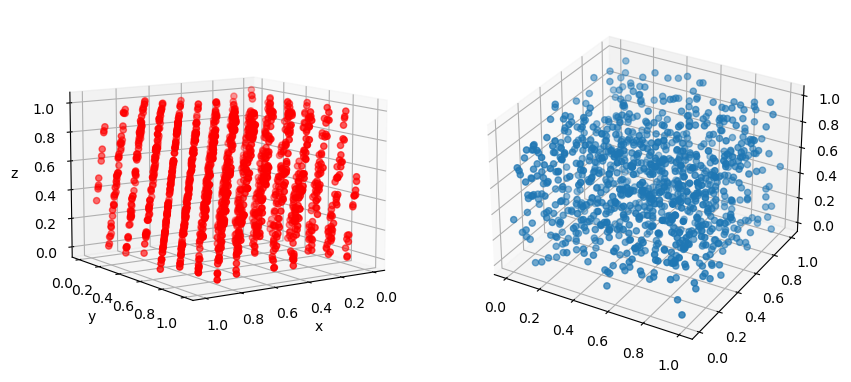

In [161]:
NUMBER_POINTS = 1000

def randssp(p,q):
        
    try: x
    except NameError:
        m = pow(2, 31)
        a = pow(2, 16) + 3
        c = 0
        x = 123456789
    
    try: p
    except NameError:
        p = 1
    try: q
    except NameError:
        q = p
    
    r = np.zeros([p,q])

    for l in range (0, q):
        for k in range (0, p):
            x = np.mod(a*x + c, m) #this is the equation shown above to generate numbers
            r[k, l] = x/m
    
    return r

k = randssp(3, 1500)

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
ax1.scatter(k[0, :], k[1, :], k[2, :], color='r')

ax2.scatter(np.random.uniform(0, 1, NUMBER_POINTS), np.random.uniform(0, 1, NUMBER_POINTS), np.random.uniform(0, 1, NUMBER_POINTS))

ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')

ax1.view_init(elev = 10, azim = 56) #the plot for the LCG is rotated in order to clearer see the planes

plt.show()

Now let's create the function required for the rest of the project. When a neutron travels through a material, e.g. water, the distance it travels before colliding with a water molecule (on average) is governed by the mean free path, $\lambda$. This is intrinsic to the material. However, the probability that the neutron travels a certain distance varies exponentially as $P(x) = e^{-\frac{x}{\lambda}}$. If we were to pick a random number which determines the distance the neutron travels, we cannot use a uniform distibution. Thus we will need to manipulate the np.random.uniform() function in order to obtain a distribution which varies exponentially. 

In order to do this, we need to consider how to samnple from an exponential distribution. If we have a probability distribution function (PDF) as:

$$pdf(x) = e^{-x}$$

Then the cumaltive distribution function (CDF) can be found as:

$$cdf(x) = \int_0^xpdf(x) = 1 - e^{-x}$$

The CDF at x tells us how likely a number between 0 and x is to be chosen. Note that the CDF goes between 0 and 1. If we take the inverse of this, we can sample points on the CDF (using a uniform distribution between 0 and 1) and gain a distribution which is exponentially distributed. The inverse of the CDF is:

$$cdf^{-1}(z) = -\ln(1-z)$$

So if $(1-z)$, or $u_i$ is a number picked from a uniform distribution (1- a random number is still a random number) then the output, $x_i$, will be exponentially distributed. This gives us the equation:

$$x_i = -\ln(u_i)$$

Using the probabilty distibution for the distance a neutron tavels for the PDF we instead get:

$$x_i = -\lambda\ln(u_i)$$

This equation will gives us a distribution for neutron travel distances which follows the PDF. 

In [163]:
EXPECTED_MEAN_FREE_PATH = 0.45

def random_exponential(mean_free_path, quantity):
    return -mean_free_path*np.log(np.random.uniform(0, 1, quantity))

def exponential_function(data, coefficient):
    return 1/coefficient*np.e**(-data/coefficient)

def linear_function(data, gradient, intercept):
    return gradient*data + intercept

def find_linear_parameters(x, y):
    try:
        expected, uncertainty = np.polyfit(x, y, 1, full = False, cov=True)
    except RuntimeError:
        print('np.polyfit was not able to find the best parameters')

    return expected, uncertainty

count, bins, ignored = plt.hist(random_exponential(EXPECTED_MEAN_FREE_PATH, NUMBER_POINTS), 15, density = True)
bin_midpoints = 0.5*(bins[1:] + bins[:-1])
p, cov = find_linear_parameters(np.log(bin_midpoints), count)
free_path, uncertainty = -p[0], np.sqrt(cov[0, 0])
plt.plot(np.linspace(0, np.max(bin_midpoints), 1000), exponential_function(np.linspace(0, np.max(bin_midpoints), 1000), free_path), color = 'red')
print('Fitted mean free path is {0:.2f} \pm {1:.3f} and mean free path coefficient put into random number generator is {2}'.format(free_path, uncertainty, EXPECTED_MEAN_FREE_PATH))

plt.xlim(0, np.max(bin_midpoints))
plt.show()

In [ ]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

number_points = 10000

def poles_gather():
    theta = np.random.uniform(0, np.pi, number_points)
    phi = np.random.uniform(0, 2*np.pi, number_points)
    xdata = np.sin(theta)*np.cos(phi)
    ydata = np.sin(theta)*np.sin(phi)
    zdata = np.cos(theta)

    return xdata, ydata, zdata

def random_unit_sphere():
    theta = np.arccos(1 - 2*np.random.uniform(0, 1, number_points))
    phi = np.random.uniform(0, 2*np.pi, number_points)
    xdata = np.sin(theta)*np.cos(phi)
    ydata = np.sin(theta)*np.sin(phi)
    zdata = np.cos(theta)

    return xdata, ydata, zdata

ax1.scatter(*poles_gather(), s=1)
ax2.scatter(*random_unit_sphere(), s=1)
plt.show()

In [ ]:
from scipy.stats import gaussian_kde

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

def normal_heat_map(axis, x_set, y_set, z_set):
    '''
    Function to generate a heat map from a given 3D datset.
    Uses a gaussian fit to determine the density of the
    values.
    
    Parameters
    ----------
    dataset : 2D array of floats
        Entire dataset for a randomly gnerated 3d region
        that follows a normal distribution.
    
    Returns
    -------
    None.
    
    '''
    density = gaussian_kde([x_set, y_set, z_set])([x_set, y_set, z_set])

    idx = density.argsort()
    x_set = x_set[idx]
    y_set = y_set[idx]
    z_set = z_set[idx]
    density = density[idx]

    axis.scatter(x_set, y_set, z_set, c=density, s=1)
    axis.set_xlabel('x')
    axis.set_ylabel('y')
    axis.set_zlabel('z')

normal_heat_map(ax1, *poles_gather())
normal_heat_map(ax2, *random_unit_sphere())

In [ ]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)

def isotropic_exponential_distribution(mean_free_path, quantity):
    theta = np.arccos(1 - 2*np.random.uniform(0, 1, quantity))
    phi = np.random.uniform(0, 2*np.pi, quantity)
    random_exponential_magnitude = random_exponential(mean_free_path, quantity)
    xdata = np.sin(theta)*np.cos(phi) * random_exponential_magnitude
    ydata = np.sin(theta)*np.sin(phi) * random_exponential_magnitude
    zdata = np.cos(theta) * random_exponential_magnitude

    return xdata, ydata, zdata

data = isotropic_exponential_distribution(EXPECTED_MEAN_FREE_PATH, number_points)
ax1.scatter(*data)

distance_data = np.sqrt(data[0]**2+data[1]**2+data[2]**2)
count, bins, ignored = ax2.hist(distance_data, 15, density = True)
bin_midpoints = 0.5*(bins[1:]+bins[:-1])
free_path, uncertainty = find_parameters(bin_midpoints, count, 'a')
ax2.plot(np.linspace(0, np.max(bin_midpoints), 1000), exponential_function(np.linspace(0, np.max(bin_midpoints), 1000), free_path), color = 'red')
print('Fitted mean free path is {0:.3f} \pm {1:.3f} and mean free path coefficient put into random number generator is {2}'.format(free_path, uncertainty, EXPECTED_MEAN_FREE_PATH))

plt.show()
    

# Complete Simulation of Absorption

For each material, we need to determine the macroscopic absorption and scattering cross sections, and the resultant total mean free path $\lambda$. The macroscopic cross-section of an event, $\Sigma$, is:

\begin{equation}
\Sigma = n\sigma
\end{equation}

where $n = \frac{\rho N_A}{M}$ and $\sigma$ is the microscopic cross-section of the event. Using the values below for the properties of the materials, we can use equation (1) to find the macroscopic cross-section.

\begin{array}{c|ccc}
    & \text{Water} & \text{Lead} & \text{Graphite}\\ \hline
   \text{Absorption}, \sigma_a (barn) & 0.6652 & 0.158 & 0.0045\\
   \text{Scattering}, \sigma_s (barn) & 103.0 & 11.221 & 4.74\\
   \text{Density}, \rho (g/cm^3) & 1.00 & 11.35 & 1.67
\end{array}

where the unit convesions to base units is $1\text{barn} = 10^{-28}m^2$ and $1g/cm^3 = 10^{3}kg/m^3$. Let's store these values into dictionaries so that we can access them easily.

In [ ]:
WATER_DICT = {'absorption_sigma': 0.6652e-28, 'scatter_sigma': 103.0e-28, 'density': 1.00e3, 'molar_mass': 18.01528e-3}
LEAD_DICT = {'absorption_sigma': 0.158e-28, 'scatter_sigma': 11.221e-28, 'density': 11.35e3, 'molar_mass': 207.2e-3}
GRAPHITE_DICT = {'absorption_sigma': 0.0045e-28, 'scatter_sigma': 4.74e-28, 'density': 1.67e3, 'molar_mass': 12.011e-3}
MATERIALS_DICT = {'water': WATER_DICT, 'lead': LEAD_DICT, 'graphite': GRAPHITE_DICT}

The total macroscopic cross-section is $\Sigma_T = \Sigma_a + \Sigma_s$ where $\Sigma_a$ is the macroscopic cross-section for absorption events and $\Sigma_s$ is the macroscopic cross-section for scattering events. To find the total mean free path, $\lambda_T$ we use:

The mean free path, average distance a particle will travel before encountering one of the events, is:

\begin{equation}
\lambda = \frac{1}{\Sigma_T} = \frac{1}{\Sigma_a+\Sigma_s}
\end{equation}

In [ ]:
def macroscopic_cross_section(density, molar_mass, cross_section):
    n = (density * const.N_A)/molar_mass
    Sigma = n*cross_section
    return Sigma

def attenuation_calculation(Sigma_absorption, Sigma_scattering):
    mean_free_path = 1/(Sigma_absorption + Sigma_scattering)
    return mean_free_path

Thus the absorption and scattering cross sections, and the resultant total mean free path are found to be (which are then added to the material's dictionary):

In [ ]:
for name, material in MATERIALS_DICT.items():
    material['macroscopic_absorption_area'] = macroscopic_cross_section(material['density'], material['molar_mass'], material['absorption_sigma'])
    material['macroscopic_scatter_area'] = macroscopic_cross_section(material['density'], material['molar_mass'], material['scatter_sigma'])
    material['mean_free_path'] = attenuation_calculation(material['macroscopic_absorption_area'], material['macroscopic_scatter_area'])
    print('The macroscopic cross-section of absorption and scattering for {0} is: {1:.3f}, {2:.3f}. The total mean free path is {3:.3f}\
    '.format(name, material['macroscopic_absorption_area'], material['macroscopic_scatter_area'], material['mean_free_path']))

For each neutron travelling through the material, we will need to simulate it travelling a distance based off of the exponential probaility distrubution function defined above. After each step, we then generate a random number between 0 and 1. If the random number is less than probaility of absorption, $p_a = \frac{\Sigma_a}{\Sigma_T}$, then the neutron is aborbed, otherwise it is scattered.

Each neutron starts from one surface of the slab (take as x = 0), and then performs a random walk where each step is drawn from the distribution $e^{-\frac{x}{\lambda_T}}$, as above. After each step, you will need to check whether the neutron is absorbed in the slab, has escaped from the slab (x < 0 or x > T), or continues onto a following step. (Hint: Use a while loop, generating the entire set of steps and their locations; a flag variable is_absorbed can be set to 1 to tell the while loop to terminate, whilst another variable i can be used to keep track of how many steps have been taken. The while loop should be continued if all of these conditions are true: x > 0 or x<T then is_absorbed == 0.

In [ ]:
NUMBER_NEUTRONS = 100
ITERATIONS= 10
dead_particles = []

class neutron():
    def __init__(self, sigma_a: float, sigma_s: float, mean_free_path: float, thickness: float):
        self.is_absorbed = False
        self.is_backscattered = False
        self.is_transmitted = False
        self.sigma_a = sigma_a
        self.sigma_s = sigma_s
        self.mean_free_path = mean_free_path
        self.thickness = thickness
        self.x_position = random_exponential(mean_free_path, 1)
        self.x_history = np.array([self.x_position])
        
    def timestep(self):
        if np.random.uniform(0, 1, 1) < (self.sigma_a/(self.sigma_a+self.sigma_s)):
            self.is_absorbed = True
        else:
            self.x_position += isotropic_exponential_distribution(self.mean_free_path, 1)[0]
            self.x_history = np.append(self.x_history, self.x_position)
            if self.x_position < 0:
                self.is_backscattered = True
            elif self.x_position > self.thickness:
                self.is_transmitted = True

def neutron_simulation_class(material:dict, thickness:float):
    particle_behaviour_class = np.zeros((0, 3))
    absorption_cross_section = material['macroscopic_absorption_area']
    scattering_cross_section = material['macroscopic_scatter_area']
    free_path = 1/(absorption_cross_section + scattering_cross_section)

    for _ in range(ITERATIONS):
        neutrons = [neutron(absorption_cross_section, scattering_cross_section, free_path, thickness) for _ in range(NUMBER_NEUTRONS)]
        number_absorbed = 0
        number_backscattered = 0
        number_transmitted = 0
        while len(neutrons) > 0:
            for index, particle in enumerate(neutrons):
                particle.timestep()
                if particle.is_absorbed == True:
                    number_absorbed += 1
                    dead_particles.append(neutrons.pop(index))
                elif particle.is_backscattered == True:
                    number_backscattered += 1
                    dead_particles.append(neutrons.pop(index))
                elif particle.is_transmitted == True:
                    number_transmitted += 1
                    dead_particles.append(neutrons.pop(index))
        particle_behaviour_class = np.vstack((particle_behaviour_class, np.array([number_absorbed, number_backscattered, number_transmitted])))
    return(particle_behaviour_class)

In [ ]:
def average_behaviour(particle_behaviour):
    average_absorbed, average_absorbed_uncertainty = np.mean(particle_behaviour[:, 0]), np.std(particle_behaviour[:, 0])
    average_backscattered, average_backscattered_uncertainty = np.mean(particle_behaviour[:, 1]), np.std(particle_behaviour[:, 1])
    average_transmitted, average_transmitted_uncertainty = np.mean(particle_behaviour[:, 2]), np.std(particle_behaviour[:, 2])
    return np.array([[average_absorbed, average_absorbed_uncertainty], [average_backscattered, average_backscattered_uncertainty], [average_transmitted, average_transmitted_uncertainty]])

def print_average_behaviour(material_name:str, averages, thickness) -> None:
    print('For {0} with a thickness of {1}m for {2} neutrons in {3} simulations, the behaviour of the neutrons is:'.format(material_name, thickness, NUMBER_NEUTRONS, ITERATIONS))
    print('Average number of absorbed neutrons: {0:.2f} \pm {1:.2f}'.format(averages[0, 0], averages[0, 1]))
    print('Average number of backscattered neutrons: {0:.2f} \pm {1:.2f}'.format(averages[1, 0], averages[1, 1]))
    print('Average number of trasmitted neutrons: {0:.2f} \pm {1:.2f}'.format(averages[2, 0], averages[2, 1]))
    return None

def behaviour_barplot(particle_behaviour):
    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(111)

    colours = ['red', 'green', 'blue']
    label_names = ['Absorbed', 'Backscattered', 'Transmitted']
    label_locations = np.linspace(0, 2.5, 3)  # the label locations
    width = (1/ITERATIONS) # the width of the bars
    for i in range(0, 3):
        for j in range(ITERATIONS):
            ax.bar(label_locations[i] - width/2 - (ITERATIONS/2 - 1)*width + j*width, particle_behaviour[j, i] / NUMBER_NEUTRONS, width, color = colours[i])

    fig.tight_layout()
    plt.xticks(label_locations, label_names, fontsize='17')
    plt.ylim(0, 1)
    plt.show()

def overall_behaviour(material_name:str, simulation_function, material_thickness):
    behaviour = simulation_function(MATERIALS_DICT[material_name], material_thickness)
    print_average_behaviour(material_name, average_behaviour(behaviour), material_thickness)
    behaviour_barplot(behaviour)

In [ ]:
SLAB_THICKNESS = 0.1
overall_behaviour('water', neutron_simulation_class, SLAB_THICKNESS)

Since the history of the x position of each neutron is stored in the class, we can plot the x position of each neutron as a function of time (each timestep) and see how the system evolves:

In [ ]:
def particle_path_plot(particles):
    maximum = 0
    for particle in particles:
        if len(particle.x_history) > maximum:
            maximum = len(particle.x_history)
        plt.plot(np.linspace(0, len(particle.x_history), len(particle.x_history)), particle.x_history)
        plt.scatter(len(particle.x_history), particle.x_history[-1])

    plt.hlines(0, 0, maximum)
    plt.hlines(SLAB_THICKNESS, 0, maximum)
    plt.ylim(-SLAB_THICKNESS / 10, SLAB_THICKNESS + SLAB_THICKNESS / 10)
    plt.xlim(0, maximum)
    plt.show()

particle_path_plot(dead_particles[-10:])
particle_path_plot(np.take(dead_particles, np.random.randint(0, len(dead_particles), 20)))

Making the simulation faster.

In [ ]:
def neutron_simulation_eff(sample_size:int, material:dict, thickness:float) -> tuple((int, int, int)):
    """
    A more efficient version of the previous code using vectorization of functions
    and using numpy instead of other function calls.
    """
    sigma_a = material['macroscopic_absorption_area']
    sigma_s = material['macroscopic_scatter_area']
    mean_free_path = attenuation_calculation(sigma_a, sigma_s)
    probability_absorption = sigma_a / (sigma_a + sigma_s) 
    absorbed = transmitted = backscattered = 0
    
    neutron_array = np.zeros((sample_size, 3))
    neutron_array[:, 0] = random_exponential(mean_free_path, sample_size)

    
    while absorbed + transmitted + backscattered < sample_size:
        neutrons_left = sample_size - transmitted - backscattered - absorbed

        transmitted += len(np.argwhere(neutron_array[:, 0] >= thickness))
        neutron_array = np.delete(neutron_array, np.argwhere(neutron_array[:, 0] >= thickness), axis = 0)
        neutrons_left = sample_size - transmitted - backscattered - absorbed

        random_reference = np.random.uniform(0, 1, neutrons_left)

        absorbed += len(np.argwhere(random_reference < probability_absorption))
        neutron_array = np.delete(neutron_array, np.argwhere(random_reference < probability_absorption), axis = 0)
        neutrons_left = sample_size - transmitted - backscattered - absorbed
        
        backscattered += len(np.argwhere(neutron_array[:, 0] < 0))
        neutron_array = np.delete(neutron_array, np.argwhere(neutron_array[:, 0] < 0), axis = 0)
        neutrons_left = sample_size - transmitted - backscattered - absorbed

        temp_x, temp_y, temp_z = isotropic_exponential_distribution(mean_free_path, neutrons_left)
        neutron_array[:, 0] += temp_x
        neutron_array[:, 1] += temp_y
        neutron_array[:, 2] += temp_z

    return (absorbed, backscattered, transmitted)

def iterative_neutron_simulation_eff(material: dict, thickness:float):
    particle_behaviour_eff = np.zeros((0, 3))
    for _ in range(ITERATIONS):
        particle_behaviour_eff = np.vstack((particle_behaviour_eff, neutron_simulation_eff(NUMBER_NEUTRONS, material, thickness))) #0 for water
    return particle_behaviour_eff

In [ ]:
NUMBER_NEUTRONS = 15000
overall_behaviour('water', iterative_neutron_simulation_eff, SLAB_THICKNESS)
overall_behaviour('lead', iterative_neutron_simulation_eff, SLAB_THICKNESS)
overall_behaviour('graphite', iterative_neutron_simulation_eff, SLAB_THICKNESS)

Calculate the variation in neutron transmission, reflection and absorption with slab
thickness for the three materials. Determine the characteristic attenuation lengths for the
three materials from the transmitted intensity, with estimated errors. Include a summary
of numerical data and representative graphs.
Hint: when fitting the transmitted neutron data you may have some thickness values
giving zero transmitted neutrons, which will stop np.polyfit from working (log(0) = -
Inf). You need to remove data points containing –Inf before fitting. 

In [ ]:
fig = plt.figure(figsize=(15, 8))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)
axes = np.array([[ax1, ax2, ax3], [ax4, ax5, ax6]])

def linear_function(data, gradient, intercept):
    return gradient*data + intercept

def find_linear_parameters(x, y, yerr):
    try:
        expected, uncertainty = np.polyfit(x, y, 1, full = False, cov=True)
    except RuntimeError:
        print('Scipy.optimize.curve_fit was not able to find the best'
              ' parameters')

    return expected, uncertainty

def varying_thickness(starting_thickness, ending_thickness, number_points):
    index = 0
    for material_name, material_dict in MATERIALS_DICT.items():
        axes[0][index].set_title(material_name)
        absorbed_behaviour = np.zeros((0, 2))
        backscattered_behaviour = np.zeros((0, 2))
        transmitted_behaviour = np.zeros((0, 2))
        thickness_array = np.geomspace(starting_thickness, ending_thickness, number_points)
        for material_thickness in thickness_array:
            average_array = average_behaviour(iterative_neutron_simulation_eff(material_dict, material_thickness)) / NUMBER_NEUTRONS
            absorbed_behaviour = np.vstack((absorbed_behaviour, average_array[0, :]))
            backscattered_behaviour = np.vstack((backscattered_behaviour, average_array[1, :]))
            transmitted_behaviour = np.vstack((transmitted_behaviour, average_array[2, :]))
        axes[0][index].errorbar(thickness_array, absorbed_behaviour[:, 0], yerr = absorbed_behaviour[:, 1], color = 'red', label = 'Absorbed')
        axes[0][index].errorbar(thickness_array, backscattered_behaviour[:, 0], yerr = backscattered_behaviour[:, 1], color = 'green', label = 'Backscattered')
        axes[0][index].errorbar(thickness_array, transmitted_behaviour[:, 0], yerr = transmitted_behaviour[:, 1], color = 'blue', label = 'Transmitted')
        axes[0][index].legend()

        xdata = np.linspace(starting_thickness, ending_thickness, 10000)
        parameters_linear, uncertainty_linear = find_linear_parameters(thickness_array, np.log(transmitted_behaviour[:, 0]), (1 / transmitted_behaviour[:, 0]) * transmitted_behaviour[:, 1])
        mean_free_path_linear, mean_free_path_uncertainty_linear = parameters_linear[0], np.sqrt(uncertainty_linear[0, 0])
        intercept, intercept_uncertainty = parameters_linear[1], np.sqrt(uncertainty_linear[1, 1])
        print('{0:.3f} \pm {1:.3f}'.format(-1 / mean_free_path_linear, (1 / (mean_free_path_linear**2))*mean_free_path_uncertainty_linear))
        axes[1][index].errorbar(thickness_array, np.log(transmitted_behaviour[:, 0]), yerr = (1 / transmitted_behaviour[:, 0]) * transmitted_behaviour[:, 1], color = 'blue', label = 'Transmitted')
        axes[1][index].plot(xdata, linear_function(xdata, mean_free_path_linear, intercept), 'k--')

        index += 1

varying_thickness(0.001, 0.2, 20)

## Woodcock method

In [ ]:
def real_step(particles, free_path, macroscopic_cross_sections, absorbed, backscattered, transmitted, max_thickness):
    #transmitted criteria
    transmitted += len(np.argwhere(particles[:, 0] > max_thickness))
    particles = np.delete(particles, np.argwhere(particles[:, 0] > max_thickness), axis = 0)
    #backscattered criteria
    backscattered += len(np.argwhere(particles[:, 0] < 0))
    particles = np.delete(particles, np.argwhere(particles[:, 0] < 0), axis = 0)
    #absorption criteria
    u = np.random.uniform(0, 1, len(particles))
    probability_absorption = macroscopic_cross_sections[0] / np.sum(macroscopic_cross_sections)
    absorbed += len(np.argwhere(u < probability_absorption))
    particles = np.delete(particles, np.argwhere(u < probability_absorption), axis = 0)
    previous_particles = particles.copy()
    #if none of the above, the particles is scattered
    particles += np.array(isotropic_exponential_distribution(free_path, len(particles))).T
    return particles, previous_particles, absorbed, backscattered, transmitted

def fictitious_step(current_position, previous_position, free_path):
    difference_vector = np.add(current_position, previous_position*-1)
    magnitude = np.sqrt(np.sum(difference_vector**2, axis = 1))
    normalised_direction = difference_vector / magnitude[:, None]
    step = normalised_direction * random_exponential(free_path, len(normalised_direction))[:, None]
    previous_position = current_position.copy()
    current_position += step
    return current_position, previous_position

def Woodcock(sample_size: int, material_one: dict, material_two: dict, thickness_1: float, thickness_2: float):
    '''
    First we are assuming that Sigma_1 < Sigma_2 --> lambda_1 > lambda_2
    '''
    macroscopic_cross_sections1 = [material_one['macroscopic_absorption_area'], material_one['macroscopic_scatter_area']]
    macroscopic_cross_sections2 = [material_two['macroscopic_absorption_area'], material_two['macroscopic_scatter_area']]
    Sigma_1 = np.sum(macroscopic_cross_sections1)
    Sigma_2 = np.sum(macroscopic_cross_sections2)
    Sigma_T = np.max([Sigma_1, Sigma_2])

    neutron_array = np.zeros((sample_size, 3))
    neutron_array_previous_step = np.zeros((sample_size, 3))
    neutron_array[:, 0] = random_exponential(1 / Sigma_1, sample_size)
    neutrons_left = sample_size

    number_absorbed = 0
    number_backscattered = 0
    number_transmitted = 0

    probability_real_step = Sigma_1 / Sigma_T

    while len(neutron_array) > 0:
        v = np.random.uniform(0, 1, neutrons_left)
        fictitious, prev_fictitious = fictitious_step(neutron_array[(v >= probability_real_step) & (neutron_array[:, 0] < thickness_1)], neutron_array_previous_step[(v >= probability_real_step) & (neutron_array[:, 0] < thickness_1)], 1 / Sigma_T)
        real_material_1, prev_1, number_absorbed, number_backscattered, number_transmitted = real_step(neutron_array[(v < probability_real_step) & (neutron_array[:, 0] < thickness_1)], 1 / Sigma_1, macroscopic_cross_sections1, number_absorbed, number_backscattered, number_transmitted, thickness_2)
        real_material_2, prev_2, number_absorbed, number_backscattered, number_transmitted = real_step(neutron_array[neutron_array[:, 0] >= thickness_1], 1 / Sigma_2, macroscopic_cross_sections2, number_absorbed, number_backscattered, number_transmitted, thickness_2)
        neutron_array = np.vstack((fictitious, real_material_1, real_material_2))
        neutron_array_previous_step = np.vstack((prev_fictitious, prev_1, prev_2))
        neutrons_left = len(neutron_array)
    return(number_absorbed, number_backscattered, number_transmitted)

particle_behaviour = np.zeros((0, 3))
for _ in range(ITERATIONS):
    particle_behaviour = np.vstack((particle_behaviour, Woodcock(15000, MATERIALS_DICT['water'], MATERIALS_DICT['water'], 0.05, 0.1)))
print_average_behaviour('water', average_behaviour(particle_behaviour), 0.1)
behaviour_barplot(particle_behaviour)
